____    
    
**Название проекта:** Нефтяной магнат
_____
**Описание исследования.**
Необходимо выбрать участок под бурение новых скважин, в котором вероятность убытков меньше 2.5% и наибольшая средняя прибыль.
_____
**Цель исследования.**
Построить модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой Bootstrap.
_____
**Задачи исследования.**
1. Загрузить и подготовить данные
2. Обучить и проверить RMSE модели для каждого региона
3. Подготовить данные к расчёту прибыли
4. Написать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели
5. Посчитать риски и прибыль для каждого региона
_____
**Исходные данные.**
Данные геологоразведки трёх регионов находятся в трех таблицах:
* geo_data_0.csv
* geo_data_1.csv
* geo_data_2.csv

В таблицах представлены следующие данные:
* id — уникальный идентификатор скважины
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы)
* product — объём запасов в скважине (тыс. баррелей)
_____
**Условия задачи.**
* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
______

**Данное исследование разделим на несколько частей.**

* [Подключение библиотек.](#1-bullet)

* [Подготовка и анализ данных.](#2-bullet)

* [Обучение и проверка моделей.](#3-bullet)

* [Подготовка данных к расчету прибыли.](#4-bullet)

* [Формирование функции для расчета прибыли.](#5-bullet)

* [Оценка рисков и прибыли.](#6-bullet)

* [Общий вывод.](#7-bullet)

<a id="1-bullet"></a>
## **Подключаемые библиотеки**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState
from sklearn.preprocessing import StandardScaler

In [ ]:
# загрузка данных
try:
  geo_data_0 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Проект по нефти/geo_data_0.csv')
  geo_data_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Проект по нефти/geo_data_1.csv')
  geo_data_2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Проект по нефти/geo_data_2.csv')
except:
  geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
  geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
  geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

<a id="2-bullet"></a>
## **Подготовка данных**

In [ ]:
# чтобы все столбцы выводились на экран
pd.set_option('display.max_columns', None)

# функция первичного анализа
def first_analysis(df):
  columns = df.columns.tolist() # формируем список из названий столбцов

  for col in columns: # для каждого  выполняем следующие команды
    print("-"*60) # линия разделитель
    print(col) # печатаем названия столбца
    print('Тип данных:', df[col].dtypes) # выводим тип данных в этом столбце
    print(f'Количество пустых ячеек: {df[col].isna().sum()} ({df[col].isna().sum()/df.shape[0]*100}%)') # выводим количество пустых ячеек в абсолютных значениях, а также в процентах
    print('Уникальные значения', df[col].unique()) # выводим список уникальных значений
  # далее по всей таблице
  print()
  print('Количество явных дубликатов:', df.duplicated().sum()) # Выводим количество явных дубликатов
  print()
  print('Первые пять строк таблицы данных')
  print()
  display(df.head()) # печатаем первые пять строк таблицы
  print('\n'*2)
  display(df.describe()) # выводим статистическую информацию по каждому столбцу
  print('\n'*2)
  df.hist(figsize=(15, 20)); # строим гистограммы для каждой колонки
  print('\n'*2)
  display(df.corr().round(2)) # строим корреляционную матрицу
  print('\n'*2)
  pd.plotting.scatter_matrix(df, figsize=(12, 9)); # выводим корреляционную матрицу графически

------------------------------------------------------------
id
Тип данных: object
Количество пустых ячеек: 0 (0.0%)
Уникальные значения ['txEyH' '2acmU' '409Wp' ... '3rnvd' '7kl59' '1CWhH']
------------------------------------------------------------
f0
Тип данных: float64
Количество пустых ячеек: 0 (0.0%)
Уникальные значения [0.70574498 1.33471129 1.02273226 ... 1.02958465 0.99816289 1.76475393]
------------------------------------------------------------
f1
Тип данных: float64
Количество пустых ячеек: 0 (0.0%)
Уникальные значения [-0.4978225  -0.34016425  0.15199044 ...  0.01878693 -0.52858167
 -0.26641676]
------------------------------------------------------------
f2
Тип данных: float64
Количество пустых ячеек: 0 (0.0%)
Уникальные значения [ 1.22116995  4.36508033  1.41992624 ... -1.34830814  1.58386866
  5.72284937]
------------------------------------------------------------
product
Тип данных: float64
Количество пустых ячеек: 0 (0.0%)
Уникальные значения [105.28006184  73.0377

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


<ipython-input-29-1e98a9427a62>:26: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  display(df.corr().round(2)) # строим корреляционную матрицу


,f0,f1,f2,product
f0,1.00,-0.44,-0.00,0.14
f1,-0.44,1.00,0.00,-0.19
f2,-0.00,0.00,1.00,0.48
product,0.14,-0.19,0.48,1.00


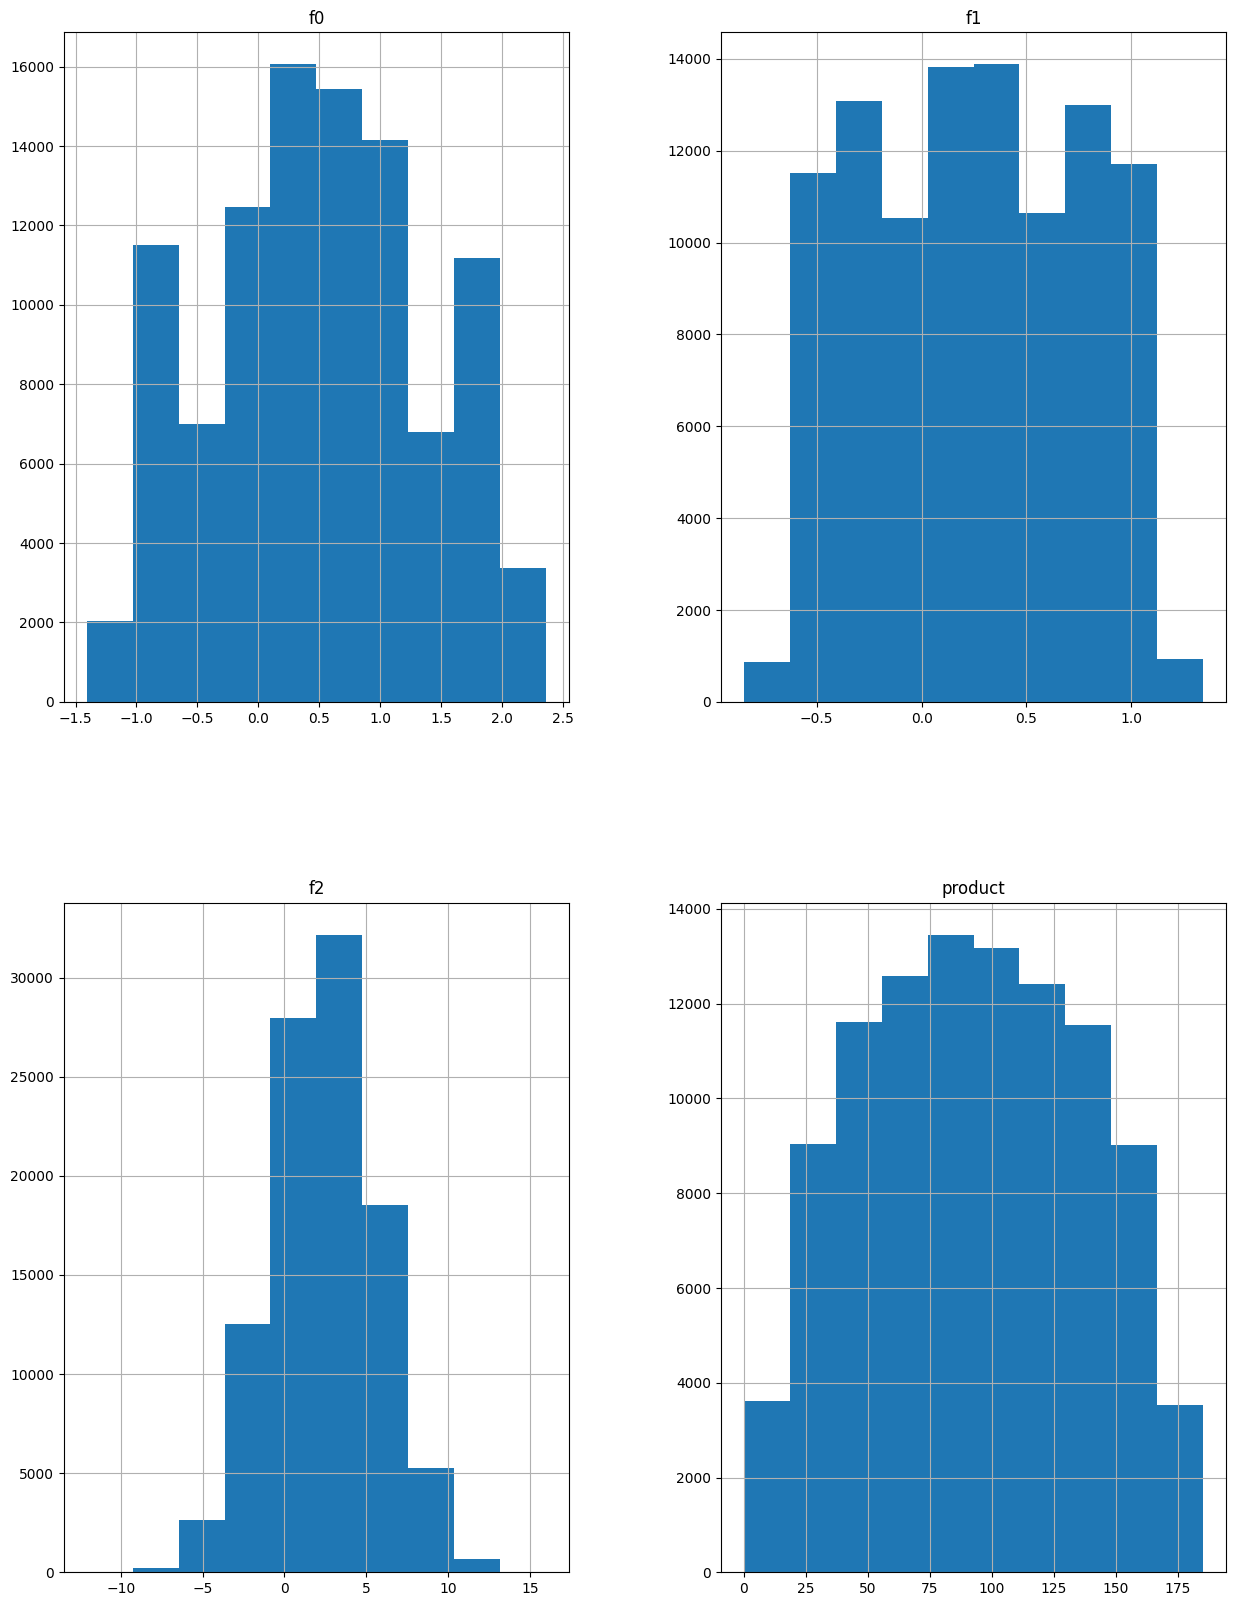

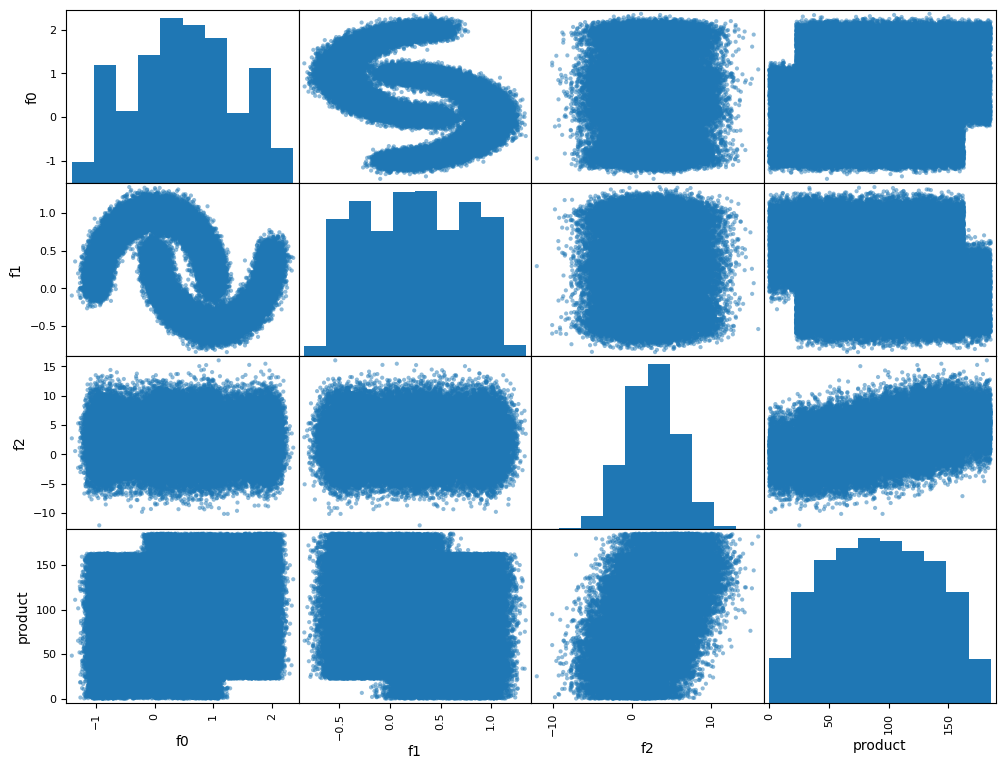

In [ ]:
# применяем функцию первичного анализа к нашим данным
first_analysis(geo_data_0)

------------------------------------------------------------
id
Тип данных: object
Количество пустых ячеек: 0 (0.0%)
Уникальные значения ['kBEdx' '62mP7' 'vyE1P' ... '09gWa' 'rqwUm' 'relB0']
------------------------------------------------------------
f0
Тип данных: float64
Количество пустых ячеек: 0 (0.0%)
Уникальные значения [-15.00134818  14.27208781   6.26318735 ...  -7.37889139   0.66571381
  -3.42613898]
------------------------------------------------------------
f1
Тип данных: float64
Количество пустых ячеек: 0 (0.0%)
Уникальные значения [-8.27599995 -3.47508322 -5.94838579 ... -3.08410387 -6.15259286
 -7.7942742 ]
------------------------------------------------------------
f2
Тип данных: float64
Количество пустых ячеек: 0 (0.0%)
Уникальные значения [-5.87601369e-03  9.99182737e-01  5.00116016e+00 ...  4.99865060e+00
  1.00014635e+00 -3.29851829e-03]
------------------------------------------------------------
product
Тип данных: float64
Количество пустых ячеек: 0 (0.0%)
Уника

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


<ipython-input-29-1e98a9427a62>:26: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  display(df.corr().round(2)) # строим корреляционную матрицу


,f0,f1,f2,product
f0,1.00,0.18,-0.0,-0.03
f1,0.18,1.00,-0.0,-0.01
f2,-0.00,-0.00,1.0,1.00
product,-0.03,-0.01,1.0,1.00


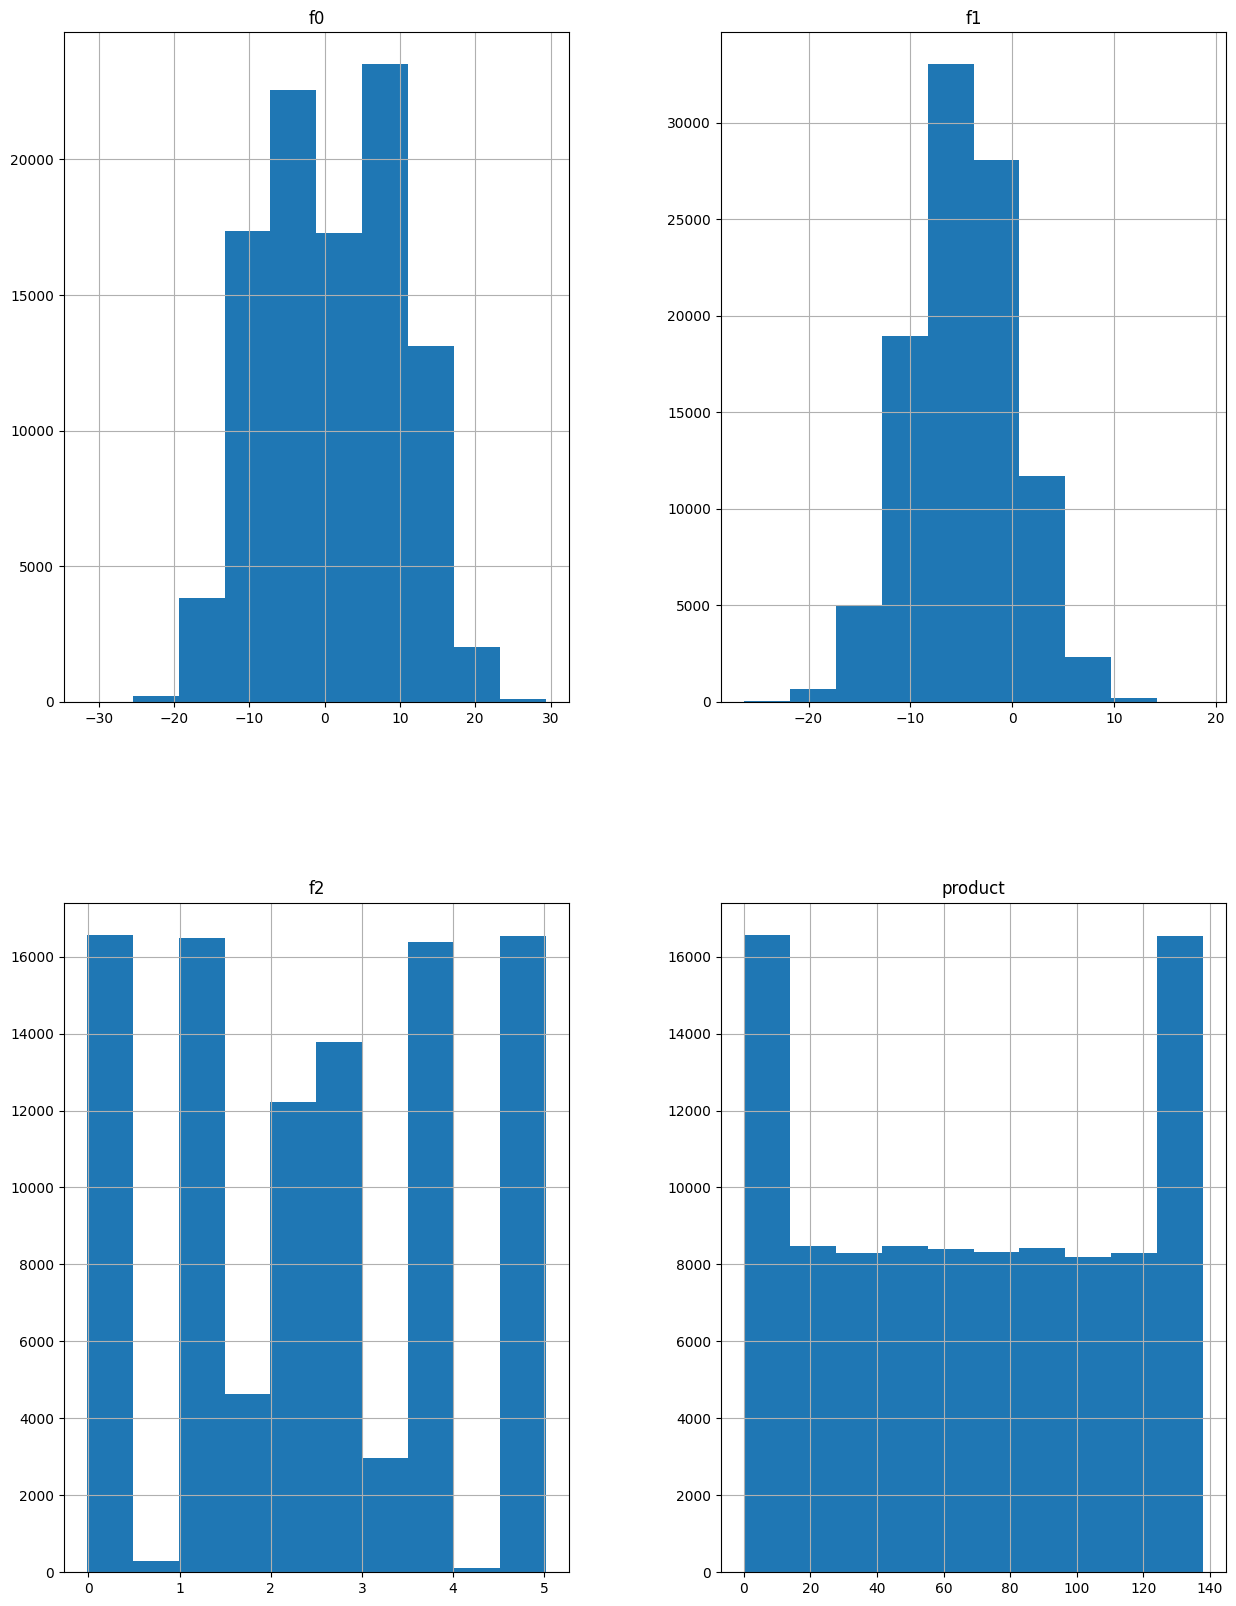

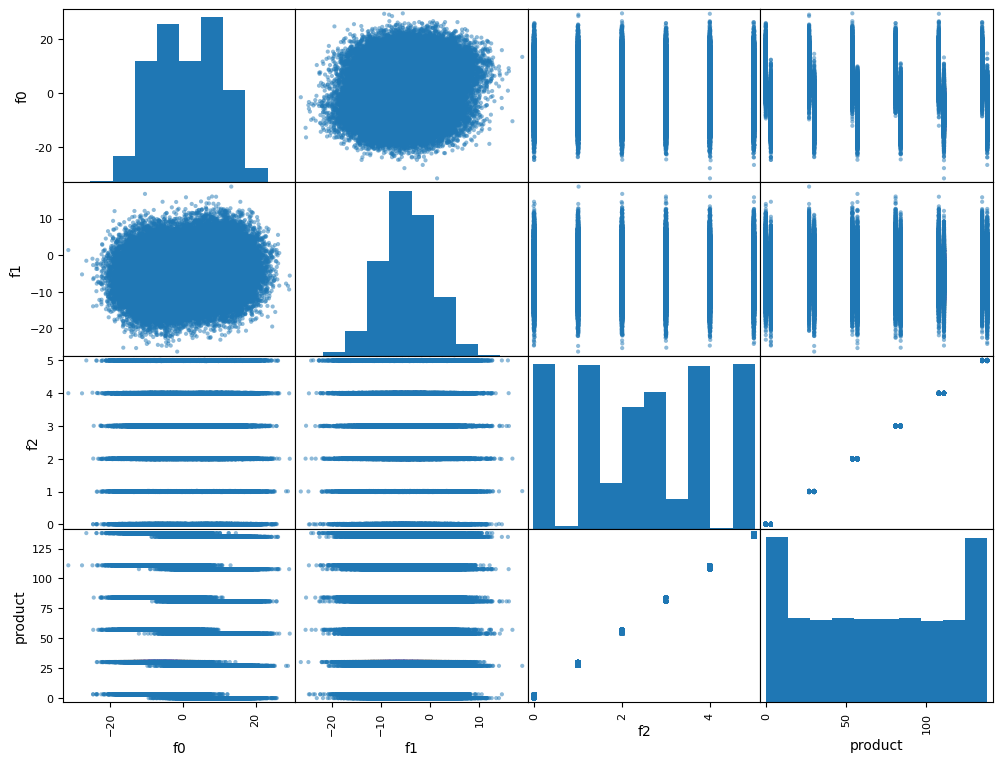

In [ ]:
first_analysis(geo_data_1)

------------------------------------------------------------
id
Тип данных: object
Количество пустых ячеек: 0 (0.0%)
Уникальные значения ['fwXo0' 'WJtFt' 'ovLUW' ... 'tKPY3' 'nmxp2' 'V9kWn']
------------------------------------------------------------
f0
Тип данных: float64
Количество пустых ячеек: 0 (0.0%)
Уникальные значения [-1.1469871   0.2627779   0.19458728 ... -1.19993432 -2.41989641
 -2.55142066]
------------------------------------------------------------
f1
Тип данных: float64
Количество пустых ячеек: 0 (0.0%)
Уникальные значения [ 0.96332792  0.26983896  0.289035   ... -2.95763723  2.41722066
 -2.02562514]
------------------------------------------------------------
f2
Тип данных: float64
Количество пустых ячеек: 0 (0.0%)
Уникальные значения [-0.82896492 -2.53018652 -5.58643277 ...  5.219411   -5.54844392
  6.09089066]
------------------------------------------------------------
product
Тип данных: float64
Количество пустых ячеек: 0 (0.0%)
Уникальные значения [ 27.75867323  

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


<ipython-input-29-1e98a9427a62>:26: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  display(df.corr().round(2)) # строим корреляционную матрицу


,f0,f1,f2,product
f0,1.0,0.0,-0.00,-0.00
f1,0.0,1.0,0.00,-0.00
f2,-0.0,0.0,1.00,0.45
product,-0.0,-0.0,0.45,1.00


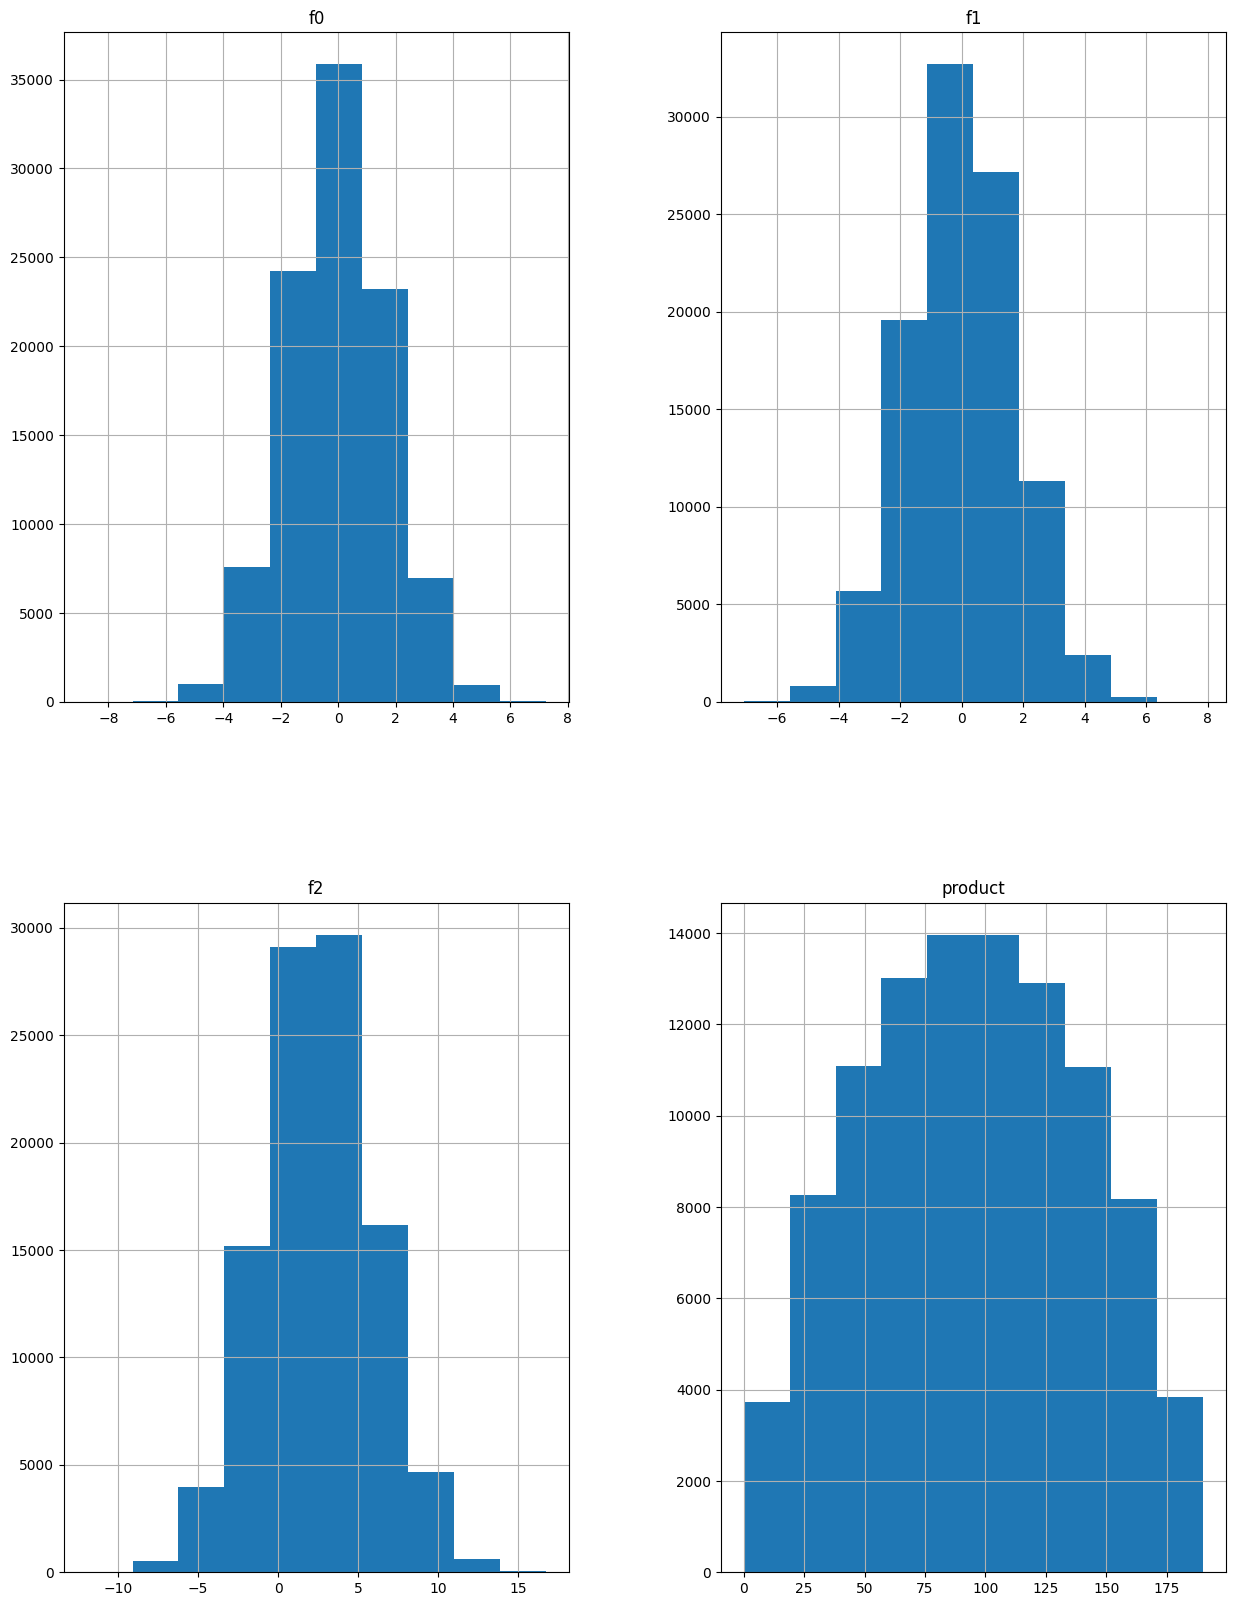

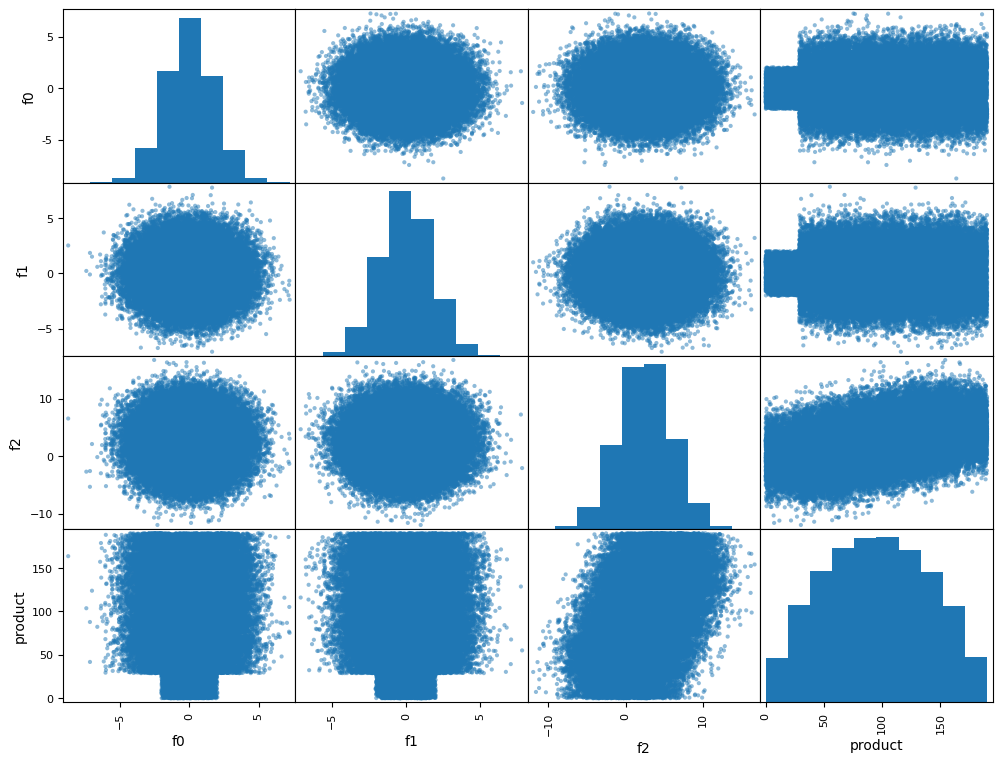

In [ ]:
first_analysis(geo_data_2)

**Вывод:** В загруженных данных представлены данные без пропусков и дубликатов. На каждом участке имеються данные по 100000 скважинам. Признаки имеет вещественный тип, id скважины строковый тип. Параметры f0, f1, f2 и product имеют нормальное распределение. Отмечается положительная корреляция между параметром f2 и product (особенно для участка 1).

<a id="3-bullet"></a>
## **Обучение и проверка моделей**

In [ ]:
# введем значение random state
RANDOM_STATE = 55555

In [ ]:
data = [geo_data_0, geo_data_1, geo_data_2]

In [ ]:
# разделим данные на обучающую и валидационную выборки по каждому участку
target = []
features = []
features_train = []
features_valid = []
target_train = []
target_valid = []

for el in data:
  target.append(el['product'])
  features.append(el.drop(['id','product'], axis=1))

for i in range(3):
  f_t, f_v, t_t, t_v = train_test_split(
    features[i], target[i], test_size=0.25, random_state=RANDOM_STATE)
  features_train.append(f_t)
  features_valid.append(f_v)
  target_train.append(t_t)
  target_valid.append(t_v)

In [ ]:
# проводим масштабирование признаков
scaler = StandardScaler()
numeric = ['f0', 'f1', 'f2']

for i in range(3):
    scaler.fit(features_train[i][numeric])
    features_train[i][numeric] = scaler.transform(features_train[i][numeric])
    features_valid[i][numeric] = scaler.transform(features_valid[i][numeric])

In [ ]:
# произведем обучение модели на данных
# рассчитаем RMSE для модели
# оценим средний запас нефти по предсказанным данным
predictions_valid = []
result = []

for i in range(3):
  model = LinearRegression()
  model.fit(features_train[i], target_train[i])
  predictions_valid.append(model.predict(features_valid[i]))
  result.append(mean_squared_error(target_valid[i], predictions_valid[i]) ** 0.5)
  print('Участок geo', i)
  print('Средний запас предсказанного сырья', predictions_valid[i].mean())
  print("RMSE модели линейной регрессии на валидационной выборке:", result[i])
  print('-' * 60)

Участок geo 0
Средний запас предсказанного сырья 92.29980563364998
RMSE модели линейной регрессии на валидационной выборке: 37.572787216783894
------------------------------------------------------------
Участок geo 1
Средний запас предсказанного сырья 68.65786052898808
RMSE модели линейной регрессии на валидационной выборке: 0.8926018653538471
------------------------------------------------------------
Участок geo 2
Средний запас предсказанного сырья 95.04059153913464
RMSE модели линейной регрессии на валидационной выборке: 40.02536281319398
------------------------------------------------------------


**Вывод:** Согласно предсказаниям моделей наибольший средний запас на скважину отмечается на участказ 0 и 2, но при этом присутсвует высокий показатель метрики RMSE (т.е. высокую валаильность). Участок 1 имеет не максимальный запас на скважину, но средне квадратичное отклонение минимальное.

<a id="4-bullet"></a>
## **Подготовка данных к расчету прибыли**

In [ ]:
# введем константы
budget = 10000000000 # бюджет на разработку в регионе
barrel_price = 450 # стоимость барреля
number_of_wells = 200 # количество скважин для разработки
number_of_point = 500 # количество скважин для исследования
state = RandomState(55555) # элемент для бутстрепа

In [ ]:
# расчитаем обьем сырья для безубыточной разработки
minimally_volume_oil = budget / barrel_price / number_of_wells / 1000
print(f' Минимальный обьем нефти для нулевой прибыли {round(minimally_volume_oil, 0)}, тыс.баррелей/скв')

 Минимальный обьем нефти для нулевой прибыли 111.0, тыс.баррелей/скв


**Вывод:** Полученное значение минимально рентабельного запаса гораздо больше средних предсказаний по запасам на наших участках. Первоначальный вывод - все из предложенных участков убыточны.

<a id="5-bullet"></a>
## **Формирование функции для расчёта прибыли по выбранным скважинам и предсказаниям модели**




In [ ]:
# напишем функцию для расчета прибыли
def revenue(target, predictions, count):
  sorted_wells = predictions.sort_values(ascending=False)
  best_wells = target[sorted_wells.index][:count]
  return best_wells.sum() * 1000 * barrel_price - budget

In [ ]:
# переведем массивы предсказаний в Series и присвоим индексы целевого признака
for i in range(3):
  predictions_valid[i] = pd.Series(predictions_valid[i], index=target_valid[i].index)

<a id="6-bullet"></a>
## **Расчет рисков и прибыли для регионов**

In [ ]:
# применяем технику Бутстреп для формирования распределения прибыли на каждом участке
values_total = []

for j in range(3):
  target_subsample = []
  probs_subsample = []
  values = []
  for i in range(1000):
    target_subsample = target_valid[j].sample(n=number_of_point, replace=True, random_state=state)
    probs_subsample = predictions_valid[j][target_subsample.index]
    values.append(revenue(target_subsample, probs_subsample, number_of_wells))
  values_total.append(values)

In [ ]:
# переведем распределение прибыли в Series
for i in range(3):
  values_total[i] = pd.Series(values_total[i])

In [ ]:
# производим вычисление и вывод на экран средней прибыли, доверительный 95% интервал, а также риск получения убытков по каждому из участков

for i in range(3):
  print('Участок geo', i)
  print(f'Средняя прибыль: {(values_total[i].mean().round(0))} руб.')
  print(f'95-% доверительный интервал: мин {(values_total[i].quantile(0.025)).round(0)}   макс {(values_total[i].quantile(0.975)).round(0)}')
  print(f'Риск убытков: {((values_total[i] < 0).mean() * 100).round(2)}%')
  print('-' * 80)

Участок geo 0
Средняя прибыль: 508187010.0 руб.
95-% доверительный интервал: мин -1171559.0   макс 1042136462.0
Риск убытков: 2.6%
--------------------------------------------------------------------------------
Участок geo 1
Средняя прибыль: 481232555.0 руб.
95-% доверительный интервал: мин 51678081.0   макс 911365300.0
Риск убытков: 1.4%
--------------------------------------------------------------------------------
Участок geo 2
Средняя прибыль: 399578573.0 руб.
95-% доверительный интервал: мин -141605703.0   макс 928901275.0
Риск убытков: 7.8%
--------------------------------------------------------------------------------


Вывод: После получения с техникой Бутстреп распределение прибыли на 1000 расчетах удалось оценить среднюю прибыль каждого участка на основе предсказаний, показать границы доверетильного итервала, а также выявить вероятность получения убытков.

Первоначальный вывод о том что все участки являються убыточными, оказался неверным. На основе полученных распределений средние прибыли положительные. Но у участков 0 и 2 выский риск получения убытов, а также доверительный интервал попадает в отрицаетльну область.

Вероятность убытка менее 2,5% имеет участкок 1. Средняя прибыль составляет 0,5 млрд руб. И именно только по этому участку 95% доверительный интревал находится в положительной зоне.

<a id="7-bullet"></a>
## **Общий вывод**

В рамках проекта было выполнено следующее:
1.   Подготовлены данные и проведен первичный анализ
2.   Проведено обучение моделей и их проверка
3.   Подготовлены данные для оценки прибыли
4.   С помощью метода Бутстреп получены массивы распределение прибыли
5.   Произведен расчет рисков и прибыли


**Рекомендуюмый к разработки - участок 1, т.к. имеет менее 2% вероятность получения убытка, а также максимальную среднюю прибыль около 500 млн. руб.**
